In [188]:
import numpy as np
import matplotlib.pyplot as plt
from nutils import mesh, function, solver
from nutils.expression_v2 import Namespace

import sys
sys.path.insert(0, '../datageneration')
from randompolynomials import randompoly1DO3, randompoly2DO3

In [386]:
def main(nelems, etype, btype, degree, inputdata, nsamples):

    #Unit square geometry and mesh
    domain, geom = mesh.unitsquare(nelems, etype)
    
    #Namespace
    ns = Namespace()
    ns.x = geom
    ns.define_for('x', gradient='∇', normal='n', jacobians=('dV', 'dS'))
    ns.basis = domain.basis(btype, degree=degree)
    ns.u = function.dotarg('lhs', ns.basis) #Solution
    
    if inputdata=='poly':
        theta = randompoly2DO3 #Conductivity
        f = randompoly2DO3 #Forcing
        etat = randompoly1DO3 #Neumann BC top
        etab = randompoly1DO3 #Neumann BC bottom
    gl = 0 #Dirichlet BC left
    gr = 0 #Dirichlet BC right
    
    ns.theta = theta(ns.x[0], ns.x[1])
    ns.f = f(ns.x[0], ns.x[1])
    ns.etat = etat(ns.x[0])
    ns.etab = etab(ns.x[0])
    ns.gl = gl
    ns.gr = gr

    #Residual
    res = domain.integral('∇_i(basis_n) theta ∇_i(u) dV' @ ns, degree=degree*2) #Stiffness
    res -= domain.integral('basis_n f dV' @ ns, degree=degree*2) #Forcing
    res -= domain.boundary['top'].integral('basis_n etat dS' @ ns, degree=degree*2) #Neumann BC
    res -= domain.boundary['bottom'].integral('basis_n etab dS' @ ns, degree=degree*2) #Neumann BC
    
    #Dirichlet BC
    sqr = domain.boundary['left'].integral('(u - gl)^2 dS' @ ns, degree=degree*2)
    sqr += domain.boundary['right'].integral('(u - gr)^2 dS' @ ns, degree=degree*2)
    cons = solver.optimize('lhs', sqr, droptol=1e-15)

    # The unconstrained entries of ``?lhs`` are to be determined such that the
    # residual vector evaluates to zero in the corresponding entries. This step
    # involves a linearization of ``res``, resulting in a jacobian matrix and
    # right hand side vector that are subsequently assembled and solved. The
    # resulting ``lhs`` array matches ``cons`` in the constrained entries.
    lhs = solver.solve_linear('lhs', res, constrain=cons)
    
    #Sampling of the input functions and solution
    bezier = domain.sample('bezier', nsamples)
    x, u = bezier.eval(['x_i', 'u'] @ ns, lhs=lhs)
    x, theta, f, etat, etab, gl, gr, u = bezier.eval(['x_i', 'theta', 'f', 'etat', 'etab', 'gl', 'gr', 'u'] @ ns, lhs=lhs)
    print(x.shape)
    
    #plot
    fig, axs = plt.subplots(1,3, figsize=(16, 4))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
    size_title = 25
    size_ticklabels = 15
    size_axeslabels = 20
    
    ax = axs[0]
    plot0 = ax.tripcolor(x[:,0], x[:,1], theta)
    ax.set_title(r"$\theta(\mathbf{x})$", fontsize=size_title)
    ax.tick_params(axis='both', labelsize=size_ticklabels)
    ax.ticklabel_format(style='sci', scilimits=[-3,3])
    ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
    ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_aspect('equal')
    fig.colorbar(plot0, ax=ax)
    
    ax = axs[1]
    plot1 = ax.tripcolor(x[:,0], x[:,1], f)
    ax.set_title(r"$f(\mathbf{x})$", fontsize=size_title)
    ax.tick_params(axis='both', labelsize=size_ticklabels)
    ax.ticklabel_format(style='sci', scilimits=[-3,3])
    ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
    ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_aspect('equal')
    fig.colorbar(plot1, ax=ax)
    
    ax = axs[2]
    ax.plot(x[:,0],etat, label=r'$\eta_\mathrm{top}(x)$')
    ax.plot(x[:,0],etab, label=r'$\eta_\mathrm{bottom}(x)$')
    ax.set_title(r"$\eta(\mathbf{x})$", fontsize=size_title)
    ax.tick_params(axis='both', labelsize=size_ticklabels)
    ax.ticklabel_format(style='sci', scilimits=[-3,3])
    ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
    ax.set_ylabel(r'$\eta(x)$', fontsize=size_axeslabels)
    ax.set_xlim(0,1)
    ax.legend(fontsize=15)
    ax.set_box_aspect(1)
    
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
    
    fig = ax.tripcolor(x[:,0], x[:,1], u)
    ax.set_title(r"$u(\mathbf{x})$", fontsize=size_title)
    ax.tick_params(axis='both', labelsize=size_ticklabels)
    ax.ticklabel_format(style='sci', scilimits=[-3,3])
    ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
    ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_aspect('equal')
    plt.colorbar(fig)
    
    return x, theta, f, etat, etab, gl, gr, u

optimize > constrained 66/1089 dofs
optimize > optimum value 0.00e+00
solve > solving 1023 dof system to machine precision using arnoldi solver
solve > solver returned with residual 1e-15
(4096, 2)


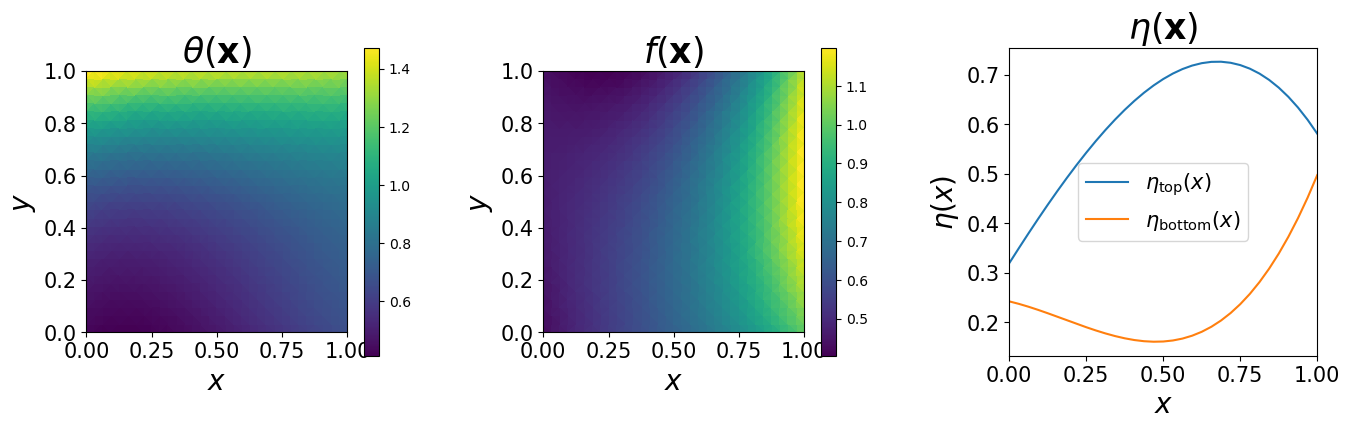

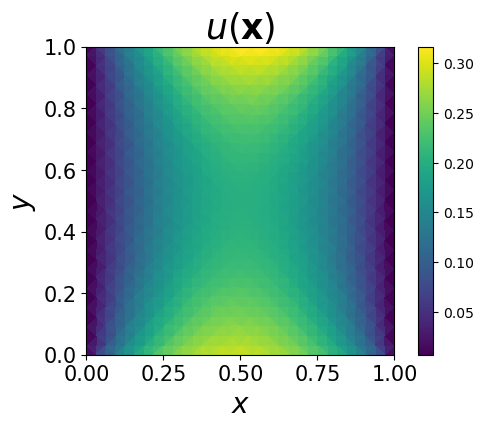

In [387]:
x, theta, f, etat, etab, gl, gr, u = main(nelems=32, etype='square', btype='spline', degree=1, inputdata='poly', nsamples=2)